In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p /content
!unzip -q /content/skin-cancer-mnist-ham10000.zip -d /content/ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100%|██████████████████████████████████████▉| 5.20G/5.20G [00:33<00:00, 160MB/s]
100%|███████████████████████████████████████| 5.20G/5.20G [00:33<00:00, 166MB/s]


In [71]:
dataset_path = '/content/ham10000'

# Ensure the dataset exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"The dataset folder {dataset_path} does not exist. Please download and extract the dataset.")

In [72]:
import os
import pandas as pd
from glob import glob 

# Load and preprocess data
df = pd.read_csv('/content/ham10000/HAM10000_metadata.csv')
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

base_skin_dir = '/content/ham10000'
image_paths = glob(os.path.join(base_skin_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in image_paths}

df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes


In [73]:
# Data augmentation and preprocessing
size = (64, 64)
transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

augmentation_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.7, contrast=0.5, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [74]:
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row['path']).convert('RGB')
        label = row['cell_type_idx']
        if self.transform:
            image = self.transform(image)
        return image, label

# Label encoding
labelEncoder = LabelEncoder()
df['label'] = labelEncoder.fit_transform(df['dx'])


In [75]:
# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [76]:
# Dataloaders
train_dataset = SkinCancerDataset(train_df, transform=augmentation_transform)
test_dataset = SkinCancerDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [80]:
import torch
import torchvision.models as tv_models
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load ResNet50
resnet50 = tv_models.resnet50(weights=None)
resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, 7)
resnet50.load_state_dict(torch.load('/kaggle/working/resnet50_model.pth', weights_only=True))
resnet50 = resnet50.to(device)
resnet50.eval()

# Load DenseNet121
densenet121 = tv_models.densenet121(weights=None)
densenet121.classifier = torch.nn.Linear(densenet121.classifier.in_features, 7)
densenet121.load_state_dict(torch.load('/kaggle/working/densenet121_model.pth', weights_only=True))
densenet121 = densenet121.to(device)
densenet121.eval()

# Load VGG16
vgg16 = tv_models.vgg16(weights=None)
vgg16.classifier[6] = torch.nn.Linear(vgg16.classifier[6].in_features, 7)
vgg16.load_state_dict(torch.load('/kaggle/working/vgg16_model.pth', weights_only=True))
vgg16 = vgg16.to(device)
vgg16.eval()

# Load VGG19
vgg19 = tv_models.vgg19(weights=None)
vgg19.classifier[6] = torch.nn.Linear(vgg19.classifier[6].in_features, 7)
vgg19.load_state_dict(torch.load('/kaggle/working/vgg19_model.pth', weights_only=True))
vgg19 = vgg19.to(device)
vgg19.eval()

# Example metric calculation
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# Add zero_division parameter to handle undefined metrics
for model_name, model in zip(["ResNet50", "DenseNet121", "VGG16", "VGG19"], [resnet50, densenet121, vgg16, vgg19]):
    all_labels, all_preds = evaluate_model(model, test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=1)
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"\nMetrics for {model_name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")



Metrics for ResNet50:
  Accuracy: 0.7798
  Precision: 0.6192
  Recall: 0.5772
  F1 Score: 0.5925

Metrics for DenseNet121:
  Accuracy: 0.7988
  Precision: 0.6830
  Recall: 0.5851
  F1 Score: 0.6200

Metrics for VGG16:
  Accuracy: 0.7698
  Precision: 0.6446
  Recall: 0.5143
  F1 Score: 0.5381

Metrics for VGG19:
  Accuracy: 0.7504
  Precision: 0.5984
  Recall: 0.4031
  F1 Score: 0.4047


In [81]:
# Combine models and weights
models = [resnet50, densenet121, vgg16]
weights = [0.4, 0.4, 0.3]

In [82]:
from torch.nn.functional import softmax

# Define the weighted ensemble function
def weighted_ensemble(models, weights, data_loader):
    weights = np.array(weights) / np.sum(weights)  # Normalize weights
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            batch_predictions = []

            # Get predictions from each model
            for model in models:
                logits = model(images)
                probabilities = softmax(logits, dim=1).cpu().numpy()
                batch_predictions.append(probabilities)

            # Weighted average of predictions
            batch_predictions = np.array(batch_predictions)
            avg_predictions = np.tensordot(batch_predictions, weights, axes=((0), (0)))
            final_predictions = np.argmax(avg_predictions, axis=1)

            all_predictions.extend(final_predictions)
            all_labels.extend(labels.numpy())

    return np.array(all_predictions), np.array(all_labels)


Precision: 0.7074
Recall: 0.6128
F1 Score: 0.6529
Accuracy: 0.8068

Classification Report:

              precision    recall  f1-score   support

       akiec       0.58      0.46      0.51        65
         bcc       0.71      0.56      0.63       103
         bkl       0.56      0.54      0.55       220
          df       0.80      0.70      0.74        23
         mel       0.88      0.96      0.92      1341
          nv       0.61      0.39      0.48       223
        vasc       0.83      0.68      0.75        28

    accuracy                           0.81      2003
   macro avg       0.71      0.61      0.65      2003
weighted avg       0.79      0.81      0.79      2003



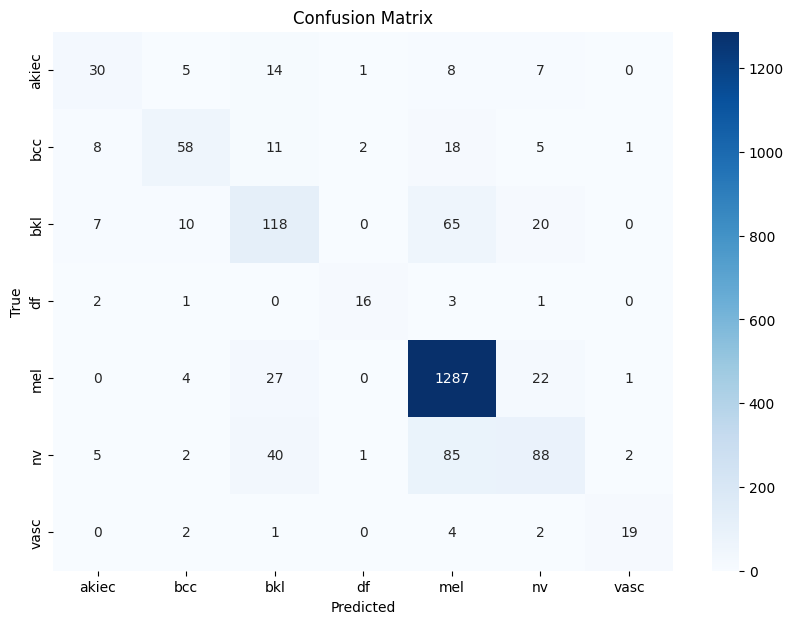

In [83]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Perform the weighted ensemble on the test set
ensemble_predictions, true_labels = weighted_ensemble(models, weights, test_loader)

# Calculate evaluation metrics
precision = precision_score(true_labels, ensemble_predictions, average='macro')
recall = recall_score(true_labels, ensemble_predictions, average='macro')
f1 = f1_score(true_labels, ensemble_predictions, average='macro')
accuracy = accuracy_score(true_labels, ensemble_predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:\n")
print(classification_report(true_labels, ensemble_predictions, target_names=labelEncoder.classes_))

# Confusion Matrix
cm = confusion_matrix(true_labels, ensemble_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labelEncoder.classes_, yticklabels=labelEncoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
